In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder, LabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble  import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)


data = pd.read_csv('input_train.csv')
label = pd.read_csv('challenge_output_data_training_file_prediction_of_transaction_claims_status.csv', ';')
all_data = data.merge(label, left_on='ID', right_on='ID', how='inner').copy()
claim_order = sorted(all_data['CLAIM_TYPE'].unique())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Fixing Structural Errors

In [2]:
# '3/2017' => 201703
temp = all_data['BUYING_DATE'].str.split('/')
all_data['BUYING_DATE'] = temp.str[1] + temp.str[0].str.zfill(2)
all_data['BUYING_DATE'] = all_data['BUYING_DATE'].astype('int32')

# Handle Missing Data

In [3]:
# To improve the Unbalanced Dataset we can delete the missing values for CLAIM_TYPE= '-'
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['BUYER_BIRTHDAY_DATE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SELLER_SCORE_AVERAGE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SHIPPING_MODE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SHIPPING_PRICE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['PRICECLUB_STATUS'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SELLER_SCORE_COUNT'].isna()) ].index)

# Numerical feature 
all_data['REGISTRATION_DATE']=all_data['REGISTRATION_DATE'].fillna(-1).values
all_data['BUYER_BIRTHDAY_DATE']=all_data['BUYER_BIRTHDAY_DATE'].fillna(-1).values
all_data['BUYING_DATE']=all_data['BUYING_DATE'].fillna(-1).values
all_data['SELLER_SCORE_AVERAGE']=all_data['SELLER_SCORE_AVERAGE'].fillna(-1).values 

# WARRANTIES_PRICE: There is not missing value but NON_WARRANTIES
all_data['WARRANTIES_PRICE']=all_data['WARRANTIES_PRICE'].fillna('NON_WARRANTIES').values 

# Categorical Features
all_data = all_data.fillna('MISSING')

# Filter Unwanted Outliers

In [4]:
# Attention that missings values = -1
all_data = all_data.drop(all_data[(all_data['BUYER_BIRTHDAY_DATE']<1940) & (all_data['BUYER_BIRTHDAY_DATE']>=0)].index)
all_data = all_data.drop(all_data[(all_data['BUYER_BIRTHDAY_DATE']>=2000) ].index)
all_data = all_data.drop(all_data[(all_data['SELLER_SCORE_AVERAGE']<40) & (all_data['SELLER_SCORE_AVERAGE']>=0)].index)

# Data Type Conversion

In [5]:
all_data['BUYER_BIRTHDAY_DATE']=all_data['BUYER_BIRTHDAY_DATE'].astype(np.int16)
all_data['SELLER_SCORE_AVERAGE']=all_data['SELLER_SCORE_AVERAGE'].astype(np.int16)
all_data['REGISTRATION_DATE']=all_data['REGISTRATION_DATE'].astype(np.int16)
all_data['BUYER_DEPARTMENT']=all_data['BUYER_DEPARTMENT'].astype(np.int16)
all_data['SELLER_DEPARTMENT']=all_data['SELLER_DEPARTMENT'].astype(np.int16)
all_data['CARD_PAYMENT']=all_data['CARD_PAYMENT'].astype(np.bool)
all_data['COUPON_PAYMENT']=all_data['COUPON_PAYMENT'].astype(np.bool)
all_data['RSP_PAYMENT']=all_data['RSP_PAYMENT'].astype(np.bool)
all_data['WALLET_PAYMENT']=all_data['WALLET_PAYMENT'].astype(np.bool)

# Sparse Classes

In [6]:
top10=all_data['SELLER_COUNTRY'].value_counts().head(10).index
all_data.loc[all_data['SELLER_COUNTRY'].isin(top10)==False,'SELLER_COUNTRY'] = 'OTHERS'

top10=all_data['SELLER_DEPARTMENT'].value_counts().head(10).index
all_data.loc[all_data['SELLER_DEPARTMENT'].isin(top10)==False,'SELLER_DEPARTMENT'] = 'OTHERS'

# Encoding

In [7]:
factor = pd.factorize(all_data['CLAIM_TYPE'])
target_number=factor[0]
target_label = factor[1]
target_vectoriser=np.vectorize(dict(zip(range(8),target_label)).get)
lb=LabelBinarizer()

####### Nominal #######
all_data = pd.concat([all_data,
                                pd.get_dummies(all_data['SHIPPING_MODE'], prefix='SHIPPING_MODE'),
                                pd.get_dummies(all_data['SELLER_COUNTRY'], prefix='SELLER_COUNTRY'),
                                pd.get_dummies(all_data['PRODUCT_TYPE'], prefix='PRODUCT_TYPE'),
                                pd.get_dummies(all_data['PRODUCT_FAMILY'], prefix='PRODUCT_FAMILY'),
                                pd.get_dummies(all_data['BUYER_DEPARTMENT'], prefix='BUYER_DEPARTMENT'),
                                pd.get_dummies(all_data['SELLER_DEPARTMENT'], prefix='SELLER_DEPARTMENT')
                           ],
                          axis=1)

#######Ordinal #######
all_data['PRICECLUB_STATUS'] = all_data['PRICECLUB_STATUS'].map( {'MISSING':0,'UNSUBSCRIBED':1, 'REGULAR': 2, 'SILVER':3, 'GOLD':4, 'PLATINUM':5}).astype(np.int16)
all_data['SHIPPING_PRICE'] = all_data['SHIPPING_PRICE'].map( {'MISSING':0,'<1':1, '1<5': 2, '5<10':3, '10<20':4, '>20':5}).astype(np.int16)
all_data['WARRANTIES_PRICE'] = all_data['WARRANTIES_PRICE'].map( {'NON_WARRANTIES':0, '<5':1, '5<20': 2, '20<50':3, '50<100':4, '100<500':5}).astype(np.int16)
all_data['PURCHASE_COUNT'] = all_data['PURCHASE_COUNT'].map( {'<5':1, '5<20': 2, '20<50':3, '50<100':4, '100<500':5, '>500':6}).astype(np.int16)
all_data['SELLER_SCORE_COUNT'] = all_data['SELLER_SCORE_COUNT'].map( {'MISSING':0,'<100':1, '100<1000': 2, '1000<10000':3, '10000<100000':4, '100000<1000000':5}).astype(np.int16)
all_data['ITEM_PRICE'] = all_data['ITEM_PRICE'].map( {'<10':0, '10<20': 1, '20<50':2, '50<100':3, '100<500':4, '500<1000':5, '1000<5000':6, '>5000':7}).astype(np.int16)


# Remove Unused Features

In [8]:
# REMOVAL OF UNUSEFUL FEATURES
all_data = all_data.drop(["ID"], axis=1)
all_data = all_data.drop(["CLAIM_TYPE"], axis=1)
all_data = all_data.drop(['WARRANTIES_FLG'],  axis=1)

# REMOVAL OF FEATURES THAT WERE ENCODED
all_data = all_data.drop(['SHIPPING_MODE'],  axis=1)
all_data = all_data.drop(['SELLER_COUNTRY'],  axis=1)
all_data = all_data.drop(['PRODUCT_FAMILY'],  axis=1)
all_data = all_data.drop(['PRODUCT_TYPE'],  axis=1)
all_data = all_data.drop(['BUYER_DEPARTMENT'],  axis=1)
all_data = all_data.drop(['SELLER_DEPARTMENT'],  axis=1)

# Feature Selection

In [40]:
numerical, categorical=list(), list()
for x in all_data.columns : 
    if x  in ['REGISTRATION_DATE','BUYER_BIRTHDAY_DATE','BUYING_DATE','SELLER_SCORE_AVERAGE', 'PRICECLUB_STATUS', 'SHIPPING_PRICE', 'WARRANTIES_PRICE', 'PURCHASE_COUNT', 'SELLER_SCORE_COUNT', 'ITEM_PRICE'] :
        numerical.append(all_data.columns.get_loc(x))
    else :
        categorical.append(all_data.columns.get_loc(x))

def print_repport(y_train, y_test, y_train_predicted, y_test_predicted):
    y_train_predicted_label = target_vectoriser(y_train_predicted)
    y_test_predicted_label = target_vectoriser(y_test_predicted)
    y_train_label = target_vectoriser(y_train)
    y_test_label = target_vectoriser(y_test)
    print('TRAIN')
    print('f1_score:      ',metrics.f1_score(y_train, y_train_predicted, average='weighted'))
    print(classification_report(y_train_label, y_train_predicted_label))
    print('TEST')
    print('f1_score:      ',metrics.f1_score(y_test, y_test_predicted, average='weighted'))
    print(classification_report(y_test_label, y_test_predicted_label))
    
def f_selector(option, data, X_train, y_train, X_test, nbrfeatures):
    if option=='CHI2':
        bestfeatures = SelectKBest(score_func=chi2, k=nbrfeatures)
        fit = bestfeatures.fit(X_train,y_train)
        dfscores = pd.DataFrame(fit.scores_)
        dfcolumns = pd.DataFrame(data.columns)
        featureScores = pd.concat([dfcolumns,dfscores],axis=1)
        featureScores.columns = ['Feature','Score']  
     
        topFeaturesIndex = featureScores.nlargest(nbrfeatures,'Score')['Feature'].index
        X_train= X_train[:,topFeaturesIndex]
        X_test = X_test[:,topFeaturesIndex]
    else:
        pca = PCA(n_components=nbrfeatures)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    return (X_train, X_test)

def run_classifier(option, data, scaler, _ncomponents):
 
    X_train, X_test, y_train, y_test = train_test_split(data, target_number, test_size=0.20, random_state=0, stratify=target_number)
    w=compute_sample_weight(class_weight='balanced', y=y_train) 
    
    #IMPUTER & SCALER 
    imputer = Imputer(strategy='mean', missing_values=-1) 
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    X_train_transformed = X_train_imputed
    X_train_transformed[:,numerical] = scaler.fit_transform(X_train_imputed[:,numerical])
    X_test_transformed = X_test_imputed
    X_test_transformed[:,numerical] = scaler.transform(X_test_imputed[:,numerical])
   
    #FEATURE SELECTION
    X = f_selector(option, data, X_train_transformed, y_train, X_test_transformed, _ncomponents)
    X_train = X[0]
    X_test = X[1]

    #CLASSIFIER
    classifier = GaussianNB()
    classifier.fit(X_train, y_train, sample_weight=w)
    y_train_predicted = classifier.predict(X_train)
    y_test_predicted = classifier.predict(X_test)
    
    #print(topFeatures['Feature'].values, '\n')
    print_repport(y_train, y_test, y_train_predicted, y_test_predicted)


def run_tunning(option, data, scaler, _ncomponents):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target_number, test_size=0.20, random_state=0, stratify=target_number)
    w=compute_sample_weight(class_weight='balanced', y=y_train) 
    
    #IMPUTER & SCALER 
    imputer = Imputer(strategy='mean', missing_values=-1) 
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    X_train_transformed = X_train_imputed
    X_train_transformed[:,numerical] = scaler.fit_transform(X_train_imputed[:,numerical])
    X_test_transformed = X_test_imputed
    X_test_transformed[:,numerical] = scaler.transform(X_test_imputed[:,numerical])

    #FEATURE SELECTION
    testScore = list()
    for i in _ncomponents:
        X = f_selector(option, data, X_train_transformed, y_train, X_test_transformed, i)
        X_train = X[0]
        X_test = X[1]

        classifier = GaussianNB()
        classifier.fit(X_train, y_train, sample_weight=w)
        y_test_predicted = classifier.predict(X_test)
        testScore.append(metrics.f1_score(y_test, y_test_predicted, average='weighted'))

    return testScore

# CHI2

Wall time: 32.2 s


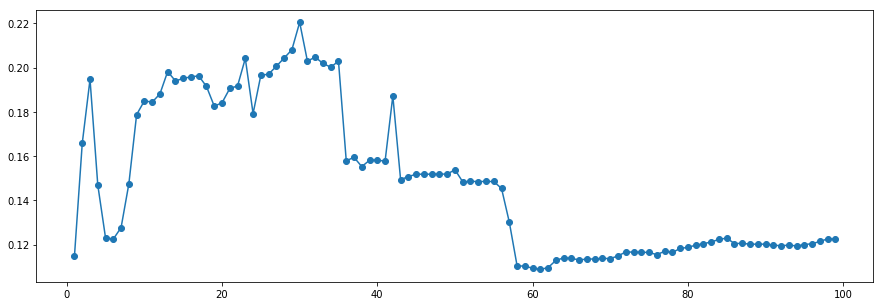

In [56]:
%%time
nbrFeatures = list(range(1,100))
testScoreChi2 = run_tunning('CHI2', all_data, Normalizer(), nbrFeatures)
plt.figure(figsize=(15,5));
plt.plot(nbrFeatures, testScoreChi2,'-o');

In [63]:
for i in range(28,35): print( i, testScoreChi2[i-1])

28 0.20433016616829983
29 0.20810132272228418
30 0.22048453920219319
31 0.20294245361989338
32 0.20476836517064467
33 0.20190443034181252
34 0.20020903650380803


In [65]:
run_classifier('CHI2', all_data, Normalizer(), 30)

TRAIN
f1_score:       0.21425575828147997
                          precision    recall  f1-score   support

                       -       0.49      0.49      0.49     12233
                 DAMAGED       0.14      0.05      0.08      4638
               DIFFERENT       0.15      0.08      0.11      3342
                    FAKE       0.00      0.94      0.01        98
            NOT_RECEIVED       0.50      0.10      0.16     11321
SELLER_CANCEL_POSTERIORI       0.62      0.12      0.20     10791
               UNDEFINED       0.19      0.04      0.07      3159
              WITHDRAWAL       0.14      0.00      0.00      5462

             avg / total       0.41      0.18      0.21     51044

TEST
f1_score:       0.22048453920219319
                          precision    recall  f1-score   support

                       -       0.49      0.49      0.49      3059
                 DAMAGED       0.14      0.05      0.07      1159
               DIFFERENT       0.17      0.10      0.12

Wall time: 30.9 s


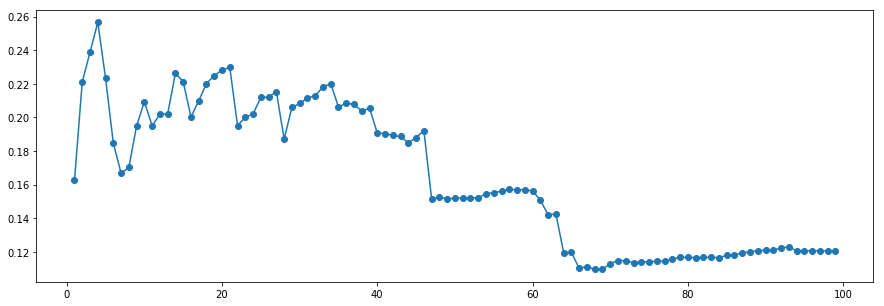

In [62]:
%%time
nbrFeatures = list(range(1,100))
testScoreMinMax = run_tunning('CHI2', all_data, MinMaxScaler(), nbrFeatures)
plt.figure(figsize=(15,5));
plt.plot(nbrFeatures, testScoreMinMax,'-o');

In [64]:
for i in range(3,8): print( i, testScoreMinMax[i-1])

3 0.23881470505126814
4 0.25660400575303954
5 0.22342345913725384
6 0.18467809535072463
7 0.16684865438206392


In [66]:
run_classifier('CHI2', all_data, MinMaxScaler(), 4)

TRAIN
f1_score:       0.2590195524141719
                          precision    recall  f1-score   support

                       -       0.52      0.89      0.65     12233
                 DAMAGED       0.19      0.32      0.24      4638
               DIFFERENT       0.05      0.00      0.01      3342
                    FAKE       0.01      0.41      0.02        98
            NOT_RECEIVED       0.00      0.00      0.00     11321
SELLER_CANCEL_POSTERIORI       0.30      0.42      0.35     10791
               UNDEFINED       0.08      0.00      0.01      3159
              WITHDRAWAL       0.11      0.04      0.05      5462

             avg / total       0.23      0.34      0.26     51044

TEST
f1_score:       0.25660400575303954
                          precision    recall  f1-score   support

                       -       0.52      0.89      0.65      3059
                 DAMAGED       0.18      0.29      0.22      1159
               DIFFERENT       0.02      0.00      0.00 

# PCA

Wall time: 3min 25s


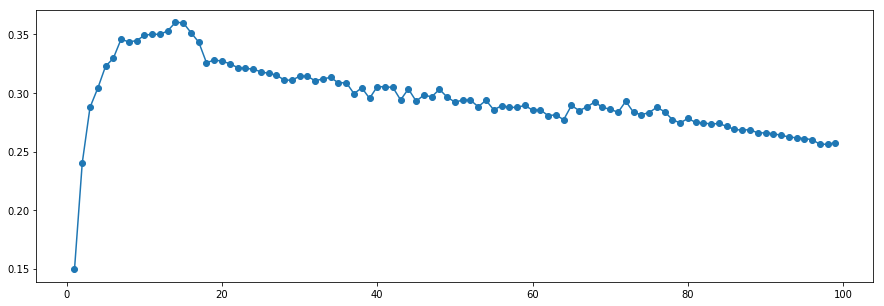

In [59]:
%%time
nbrFeatures = list(range(1,100))
testScorePCA = run_tunning('PCA', all_data, StandardScaler(), nbrFeatures)
plt.figure(figsize=(15,5));
plt.plot(nbrFeatures, testScorePCA,'-o');

In [60]:
for i in range(12,18): print( i, testScorePCA[i-1])

12 0.3499098827040774
13 0.3529700999452347
14 0.360223709814304
15 0.3599022670813107
16 0.3514830695752999
17 0.34335951729269887


In [61]:
run_classifier('PCA', all_data, StandardScaler(), 14)

TRAIN
f1_score:       0.3574577722356202
                          precision    recall  f1-score   support

                       -       0.58      0.72      0.64     12233
                 DAMAGED       0.20      0.27      0.23      4638
               DIFFERENT       0.13      0.19      0.15      3342
                    FAKE       0.01      0.50      0.02        98
            NOT_RECEIVED       0.46      0.26      0.33     11321
SELLER_CANCEL_POSTERIORI       0.41      0.28      0.33     10791
               UNDEFINED       0.15      0.12      0.13      3159
              WITHDRAWAL       0.22      0.16      0.19      5462

             avg / total       0.39      0.35      0.36     51044

TEST
f1_score:       0.36031311277043204
                          precision    recall  f1-score   support

                       -       0.58      0.73      0.65      3059
                 DAMAGED       0.19      0.26      0.22      1159
               DIFFERENT       0.12      0.17      0.14 